#### 5 year Forecasting With ResellerSales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '0' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Reseller,2024.994,Southeast
1,2011-05-31,Reseller,6074.982,Southeast
2,2011-05-31,Reseller,2024.994,Southeast
3,2011-05-31,Reseller,2039.994,Southeast
4,2011-05-31,Reseller,2039.994,Southeast
...,...,...,...,...
60914,2014-05-01,Reseller,316.860,Southwest
60915,2014-05-01,Reseller,809.760,Southwest
60916,2014-05-01,Reseller,3274.800,Southwest
60917,2014-05-01,Reseller,97.182,Southwest


In [3]:
df.OrderDate.max() 

Timestamp('2014-05-01 00:00:00')

In [4]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [5]:
online_channel= df.loc[df['Region'] == 'France',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
8903,2012-05-30,Reseller,647.9940,France
8904,2012-05-30,Reseller,141.6150,France
8905,2012-05-30,Reseller,1488.5454,France
8980,2012-05-30,Reseller,42.3867,France
8981,2012-05-30,Reseller,179.9760,France
...,...,...,...,...
59772,2014-05-01,Reseller,200.0520,France
59773,2014-05-01,Reseller,14.6940,France
59812,2014-05-01,Reseller,1430.4420,France
59813,2014-05-01,Reseller,5.9880,France


### Data Preprocessing

In [6]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [7]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2012-05-30,98193.7850
1,2012-06-30,265354.8329
2,2012-07-31,164075.3925
3,2012-08-30,55940.1844
4,2012-09-30,189348.6767
5,2012-10-30,87995.2931
6,2012-11-30,34522.3828
7,2012-12-31,143191.2530
8,2013-01-28,61164.9646
9,2013-02-28,56947.6248


### Indexing with Time Series Data

In [8]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2012-05-30', '2012-06-30', '2012-07-31', '2012-08-30',
               '2012-09-30', '2012-10-30', '2012-11-30', '2012-12-31',
               '2013-01-28', '2013-02-28', '2013-03-30', '2013-04-30',
               '2013-05-30', '2013-06-30', '2013-07-31', '2013-08-30',
               '2013-09-30', '2013-10-30', '2013-11-30', '2013-12-31',
               '2014-01-29', '2014-03-01', '2014-03-31', '2014-05-01'],
              dtype='datetime64[ns]', name='OrderDate', freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [9]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [10]:
y['2014':]

OrderDate
2014-01-01     88588.1414
2014-02-01    331518.1421
2014-03-01    331518.1421
2014-04-01    119587.0479
2014-05-01    119587.0479
Freq: MS, Name: Total_Sales, dtype: float64

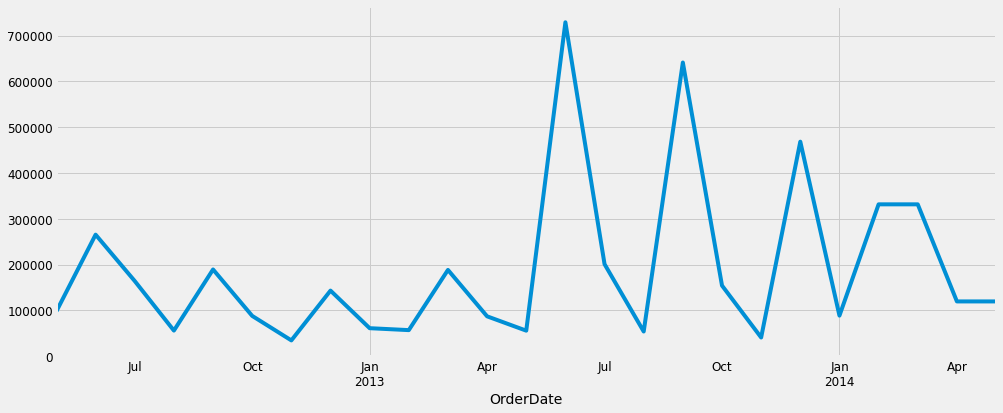

In [11]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

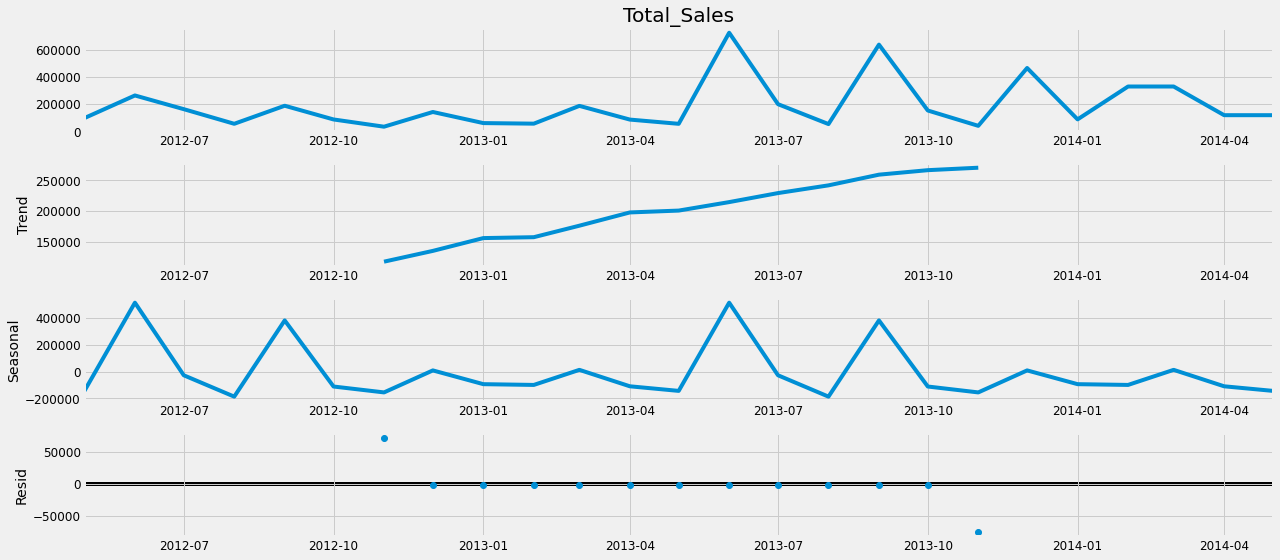

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [14]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:669.8086305805125
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:321.46014219112163
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:336.4610958624979
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:346.0699969840294
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:323.9899869522254
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:29.914050663144
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:639.8129713633118
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:302.9083388958247
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:303.02772998480935
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:357.2391408320816
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:304.6827860217872
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:32.391568891708125
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:645.2294818458287
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:305.33660962164385
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:310.66251741196555
ARIMA(0,

 ### Fitting an ARIMA Time Series Model

In [15]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4468         -0        inf      0.000      -0.447      -0.447
ma.L1         -0.7905         -0        inf      0.000      -0.791      -0.791
ar.S.L12            0         -0        nan        nan           0           0
ma.S.L12            0         -0        nan        nan           0           0
sigma2      2.929e+10         -0       -inf      0.000    2.93e+10    2.93e+10


### Validating forecasts

In [18]:
pred = results.get_prediction(start=pd.to_datetime('2012-06-1'), end=pd.to_datetime('2014-05-01 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()



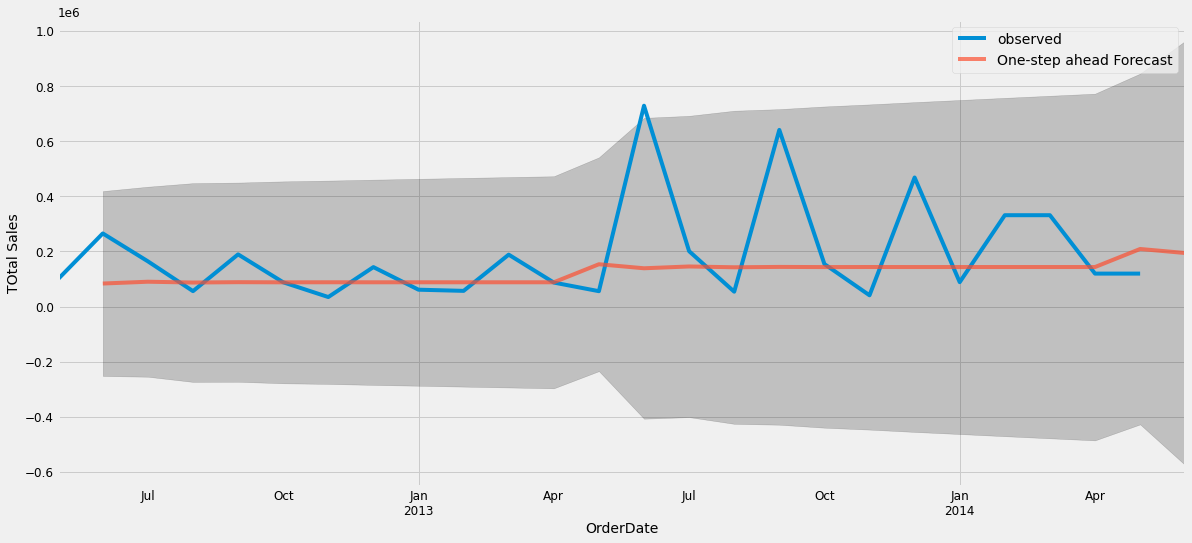

In [19]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()

plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 16461068943.87


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 128300.7


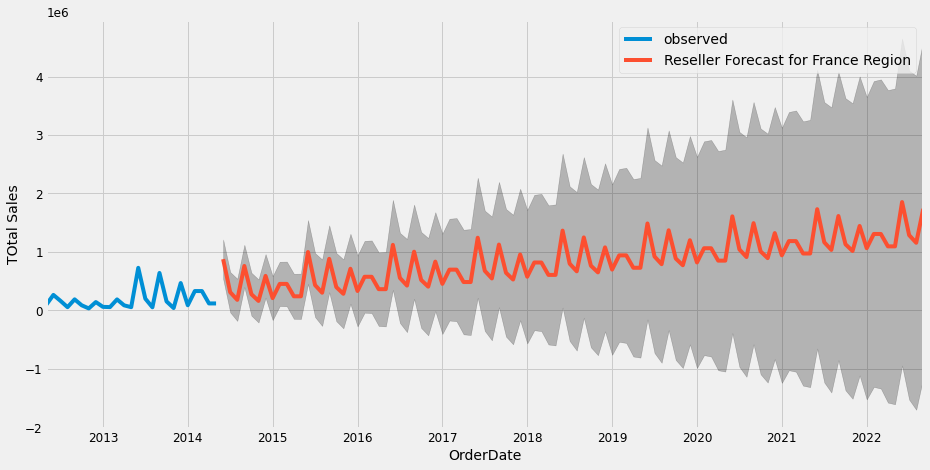

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Reseller Forecast for France Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('TOtal Sales')
plt.legend()
plt.show()